<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SOLUTION 2**

Installation de transformers et tout ce qu'on a besoin

In [ ]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Librairies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import AutoTokenizer
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mount du drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Challenge2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Challenge2'
/content/drive/.shortcut-targets-by-id/1aIAK0Qi-pofkSLi3xijkAex-JrSW_tn8/Challenge2


Lecture de données

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')

Supprimer les colonnes inutiles

In [ ]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

Delete les lignes parasites
-	1136 : suite du mot ISLAM.
-	1180 : data en arabe
-	1317 : pas de data.
-	1362 : suite du mot ROUEN.
-	1429 : suite de 1 et 0. 

In [ ]:
df_train.drop([1136, 1180, 1317, 1362, 1429], inplace = True )

Ajout de données additionnelles

In [ ]:
df_real = pd.read_csv("real_news.csv")
df_fake = pd.read_csv("fake_news.csv")
df_real = df_real.drop(['site', 'url', 'title'], axis = 1)
df_fake = df_fake.drop(['site', 'url', 'title'], axis = 1)
df_real['label'] = 0
df_fake['label'] = 1
df_real.rename(columns = {'text':'data'}, inplace = True)
df_fake.rename(columns = {'text':'data'}, inplace = True)
df_train = df_train.append(df_real, ignore_index = True)
df_train = df_train.append(df_fake, ignore_index = True)

df_train['data'] = df_train['data'].astype(str)
df_test['data'] = df_test['data'].astype(str)

Nettoyage de données

In [ ]:
STOPWORDS = set(stopwords.words('french'))
moreStopwords = ['plus', 'comme', 'a', 'il', 'alors','au',
'aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces','ceux','chaque','ci',
'comme','comment','dans','des','du','dedans','dehors','depuis','devrait','doit','donc','dos','début',
'elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il',
'ils','je',	'juste','la','le','les','leur','là','ma','maintenant','mais','mes','mien','moins','mon',
'mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas','peut','peu','plupart','pour',
'pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement','si',
'sien','son','sont','sous','soyez',	'sujet','sur','ta','tandis','tellement','tels','tes','ton','tous',
'tout','trop','très','tu','voient','vont','votre','vous','vu','ça','étaient','état','étions','été','être',
'cette','celle','dont','celui', 'adsbygoogle','window','secretnews','leurs','ainsi','toute','déjà','autres',
'suivre','facebook','twitter','parodique', 'média','collaboratif', 'libre','notamment']

STOPWORDS.update(moreStopwords)
def cleaner(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

In [ ]:
df_train['data'] = df_train['data'].apply(cleaner)
df_test['data'] = df_test['data'].apply(cleaner)

Shuffle le dataset

In [ ]:
df_train = df_train.append(df_test, ignore_index=True)
shuffled = df_train.sample(frac=1).reset_index()
shuffled = shuffled.drop(['index'], axis = 1)

Définition du bloque transformer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Définition de la couche d'embedding

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Choix de tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
def preprocess_function(text):
    return tokenizer(text, truncation=True, padding=True)

Traitement de data pour mettre sous la bonne forme pour l'entrainement

In [ ]:
label = shuffled.pop('label')
text = shuffled.pop('data')

In [ ]:
label_arr = label.to_numpy()
text_arr = text.to_numpy()

In [ ]:
for i in range(len(text_arr)):
  text_arr[i] = preprocess_function(text_arr[i]).input_ids

Split en train, test, val

In [ ]:
def split_list(a_list, p):
    split = int(len(a_list)//(1/(1-p)))
    return a_list[:split], a_list[split:]
x_train, x_test = split_list(text_arr, 0.25)
y_train, y_test = split_list(label_arr, 0.25)
x_train, x_val = split_list(x_train, 0.30)
y_train, y_val = split_list(y_train, 0.30)

Padding

In [ ]:
maxlen = 200  # Only consider the first 200 words of each movie review
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

11066 Training sequences
4743 Validation sequences


Définition du modèle et choix de paramètres

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size = 210000
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          6726400   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 200, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 32)                0   

le model.fit()

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val),callbacks = [learning_rate_reduction]
)

Epoch 1/20
346/346 [==============================] - 48s 135ms/step - loss: 0.4337 - accuracy: 0.7856 - val_loss: 0.2132 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 2/20
346/346 [==============================] - 45s 131ms/step - loss: 0.1234 - accuracy: 0.9620 - val_loss: 0.1989 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 3/20
346/346 [==============================] - 47s 137ms/step - loss: 0.0446 - accuracy: 0.9878 - val_loss: 0.2891 - val_accuracy: 0.9315 - lr: 0.0010
Epoch 4/20
346/346 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9939
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
346/346 [==============================] - 45s 130ms/step - loss: 0.0235 - accuracy: 0.9939 - val_loss: 0.3086 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 5/20
346/346 [==============================] - 45s 130ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.3811 - val_accuracy: 0.9338 - lr: 5.0000e-04
Epoch 6/20
346/346 [=========================

Save le model

In [ ]:
savepath = '/content/drive/MyDrive/Challenge2/transformer1.h5'

In [ ]:
model.save(savepath)

Evaluation du model

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Validating Data is - " , model.evaluate(x_val,y_val)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

346/346 [==============================] - 12s 34ms/step - loss: 0.0020 - accuracy: 0.9998
Accuracy of the model on Training Data is -  99.9819278717041 %
149/149 [==============================] - 5s 33ms/step - loss: 0.4652 - accuracy: 0.9351
Accuracy of the model on Validating Data is -  93.50621700286865 %
165/165 [==============================] - 5s 33ms/step - loss: 0.4335 - accuracy: 0.9387
Accuracy of the model on Testing Data is -  93.87096762657166 %


Graphique de l'entrainement
A chaque entrainement nous avons constaté des graphiques plus ou moins similaires. Ce type de graphique est typique lors d'un overfitting. Et c'est le cas. Nous avons une très bonne accuracy et loss sur training data et on plafonne sur le validation. Nous avons essayé plusieurs changements: 

-Ajouter un dropout et le faire varier

-Augmenter la taille des données de validation

-Diminuer le learning rate lorsqu'on n'améliore plus la val_loss

-L'ajout des nouvelles data n'a pas changé le résultat non plus

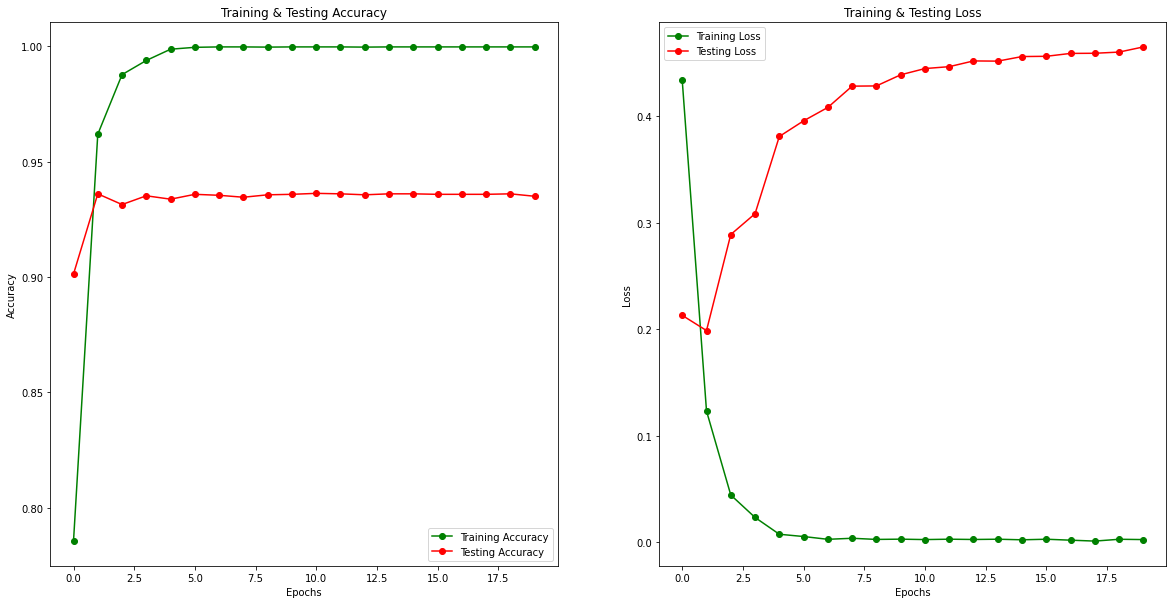

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()